In [11]:
import os
import re
import torch
import pickle
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
DATA_DIR = Path("../data/k0/discontinuities")

In [13]:
labels = pickle.load(open("../data/k0/sentiment-analysis/labels.pkl", "rb"))
# convert all of the labels to ints 
labels = [int(v) for v in labels]

In [14]:
MODELS = [
    "bert-large-uncased-imdb",
    "bert-base-uncased-imdb",
    "roberta-base-imdb",
    "roberta-large-imdb",
    "gpt2-imdb",
    "t5-base-imdb",
    "t5-small-imdb",
    #"xlnet-imdb",
    #"TinyLlama-1.1B-Chat-v1.0"
]

num_layers = [
    24,
    12,
    12,
    24,
    12,
    12,
    6,
    #12,
    #22
]

layer_map = {}

for i in range(len(num_layers)):
    layer_map[MODELS[i]] = num_layers[i]

In [15]:
def get_stuff(delta=0.3, epsilon=0.15, depth=0.75):
    layer = depth
    
    X = []
    
    # for the given delta value, epsilon value, and layer, read the discontinuities
    for i, m in enumerate(MODELS):
        which_layer = 0
    
        if layer < 1:
            # proportion
            which_layer = int(layer * num_layers[i])
        
        file_name = DATA_DIR / f"{m}/L{which_layer - 1}.pth"
    
        disconts = torch.load(file_name)
        
        # file format for disconts is: 
        # 1000 rows, for each value of delta
        # 15000 columns, one for each data point
        # each item is the min value of epsilon for which it will be a discontinuity
        
        row_idx = int(delta * 1000)
        
        ret = []
        
        row = disconts[row_idx].detach().cpu().numpy()
        
        ret = np.sum(np.where(row > epsilon, 1, 0))
        
        X.append(ret)
    
    X = np.asarray(X)

    return X

grid = [[[[] for i in range(3)] for i in range(4)] for i in range(4)]

for i, delta in enumerate([0.15, 0.3, 0.45, 0.6]):
    for j, epsilon in enumerate([0.15, 0.3, 0.45, 0.6]):
        for k, depth in enumerate([0.25, 0.5, 0.75]):
            grid[i][j][k] = get_stuff(delta, epsilon, depth)

In [16]:
import pickle

# Example: Load an object from a pickle file
filename = 'gridsearch.pkl'

# Open the file in binary read mode ('rb')
with open(filename, 'wb') as file:
    pickle.dump(grid, file)

In [17]:
for i in range(4):
    for j in range(4):
        print(grid[i][j][2])

[   0    0    0    0 1009    0  103]
[  0   0   0   0 931   0   0]
[  0   0   0   0 886   0   0]
[  0   0   0   0 834   0   0]
[ 779  813  159  304 1070  674 1140]
[698 273  92  32 998 146 633]
[475   1   0   0 957   0 336]
[195   0   0   0 910   0   0]
[ 862 1219  398  699 1070 1275 1219]
[ 840  846  291  644  998  645 1021]
[816 488   0 415 957 256 606]
[801 138   0   6 910  26 206]
[ 862 1323  731  709 1072 1542 1262]
[ 840 1007  652  699  999  929 1101]
[818 753  33 672 958 504 948]
[806 406   0 446 910 152 471]


In [35]:
delta = 0.3
epsilon = 0.3
layer = 0.75#1./2.

X = []

# for the given delta value, epsilon value, and layer, read the discontinuities
for i, m in enumerate(MODELS):
    which_layer = 0

    if layer < 1:
        # proportion
        which_layer = int(layer * num_layers[i])
    
    file_name = DATA_DIR / f"{m}/L{which_layer - 1}.pth"

    print(i, m, which_layer)
    
    disconts = torch.load(file_name)
    
    # file format for disconts is: 
    # 1000 rows, for each value of delta
    # 15000 columns, one for each data point
    # each item is the min value of epsilon for which it will be a discontinuity
    
    row_idx = int(delta * 1000)
    
    ret = []
    
    row = disconts[row_idx].detach().cpu().numpy()
    
    ret = np.where(row > epsilon, 1, 0)
    
    X.append(ret)

X = np.asarray(X)

0 bert-large-uncased-imdb 18
1 bert-base-uncased-imdb 9
2 roberta-base-imdb 9
3 roberta-large-imdb 18
4 gpt2-imdb 9
5 t5-base-imdb 9
6 t5-small-imdb 4


In [36]:
gpt2_t5 = np.linalg.norm(X[4] - X[5])

In [37]:
gpt2_bert = np.linalg.norm(X[4] - X[1])

In [38]:
print(gpt2_t5 / gpt2_bert)

0.9972994819722805


In [39]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(X)

In [42]:
similarities

array([[ 0.        , 24.91987159, 25.25866188, 26.2297541 , 30.09983389,
        25.53429067, 28.44292531],
       [24.91987159,  0.        , 16.64331698, 17.17556404, 30.4466747 ,
        15.96871942, 23.83275058],
       [25.25866188, 16.64331698,  0.        , 11.04536102, 30.29851482,
        13.03840481, 24.4744765 ],
       [26.2297541 , 17.17556404, 11.04536102,  0.        , 31.27299154,
        13.26649916, 25.70992026],
       [30.09983389, 30.4466747 , 30.29851482, 31.27299154,  0.        ,
        30.3644529 , 31.22498999],
       [25.53429067, 15.96871942, 13.03840481, 13.26649916, 30.3644529 ,
         0.        , 23.60084744],
       [28.44292531, 23.83275058, 24.4744765 , 25.70992026, 31.22498999,
        23.60084744,  0.        ]])

In [43]:
kd_similarity_ranks = []

k = 7  # Consider the top 2 most similar elements

# Iterate through each row (or column)
for row in similarities:
  # Sort elements in descending order and get indices
  sorted_indices = row.argsort()[::-1][:k]  # Top k most similar elements
  kd_similarity_ranks.append(sorted_indices.tolist())

# Print the rankings
print(kd_similarity_ranks)

[[4, 6, 3, 5, 2, 1, 0], [4, 0, 6, 3, 2, 5, 1], [4, 0, 6, 1, 5, 3, 2], [4, 0, 6, 1, 5, 2, 3], [3, 6, 1, 5, 2, 0, 4], [4, 0, 6, 1, 3, 2, 5], [4, 0, 3, 2, 1, 5, 6]]


In [45]:
seed = 42

mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    #dissimilarity="precomputed",
    n_jobs=1,
    #normalized_stress="auto",
)
#pos = mds.fit(X).embedding_
pos = mds.fit_transform(X)

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    #dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
    #normalized_stress=True
)
npos = nmds.fit_transform(X, init=pos)

In [25]:
# Rescale the data
#pos *= np.sqrt((X**2).sum()) / np.sqrt((pos**2).sum())
#npos *= np.sqrt((X**2).sum()) / np.sqrt((npos**2).sum())

In [26]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

In [27]:
from adjustText import adjust_text

4.697424019278693e-18
-0.18898223650461343 , -1.3426797785182902e-08 , bert-large-uncased-imdb
-0.18898223650461346 , 1.4394814390490754e-08 , bert-base-uncased-imdb
-0.18898223650461377 , 3.787899706322932e-09 , roberta-base-imdb
-0.18898223650461363 , -8.96755598027442e-09 , roberta-large-imdb
1.1338934190276815 , -1.1682265852137383e-17 , gpt2-imdb
-0.18898223650461365 , -9.659933372442419e-09 , t5-base-imdb
-0.18898223650461346 , 1.38715729709925e-08 , t5-small-imdb


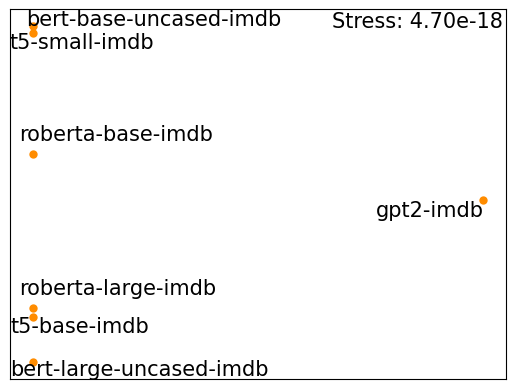

In [28]:
clf = PCA(n_components=2)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#npos = scaler.fit_transform(npos)

fig, ax = plt.subplots()

#ax.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
ax.scatter(npos[:, 0], npos[:, 1], color="darkorange", lw=0, label="NMDS")
#plt.legend(scatterpoints=1, loc="best", shadow=False)

"""
# Add annotations for data points without overlapping
spacing = 0.03  # Adjust this value to control the spacing between annotations
for i, txt in enumerate(MODELS):
    x, y = npos[i][0], npos[i][1]
    for other_i, other_txt in enumerate(MODELS):
        if i != other_i:
            other_x, other_y = npos[other_i][0], npos[other_i][1]
            if abs(x - other_x) < spacing and abs(y - other_y) < spacing:
                if x < other_x:
                    x -= spacing
                else:
                    x += spacing
                if y < other_y:
                    y -= spacing
                else:
                    y += spacing
    ax.annotate(txt, (x, y))
"""

texts = []

# Adding labels to data points
for i, txt in enumerate(MODELS):
    if False:#txt == 'TinyLlama-1.1B-Chat-v1.0':
        texts.append(ax.text(npos[i][0], npos[i][1] + 0.3, f"{txt}", fontsize=10, ha='center', va='bottom'))
    else:
        texts.append(ax.text(npos[i][0], npos[i][1], f"{txt}", fontsize=15, ha='center', va='bottom'))

adjust_text(texts)

# If you want to calculate the normalized stress:
normalized_stress = np.sqrt(nmds.stress_) / np.sqrt(np.sum(similarities**2))

print(normalized_stress)

ax.text(0.65, 0.95, f'Stress: {normalized_stress:.2e}', transform=ax.transAxes, fontsize=15)

plt.xticks([])
plt.yticks([])

for i, txt in enumerate(MODELS):
    print(npos[i][0], ',', npos[i][1], ',', txt)

plt.savefig('nmds-3.pdf')

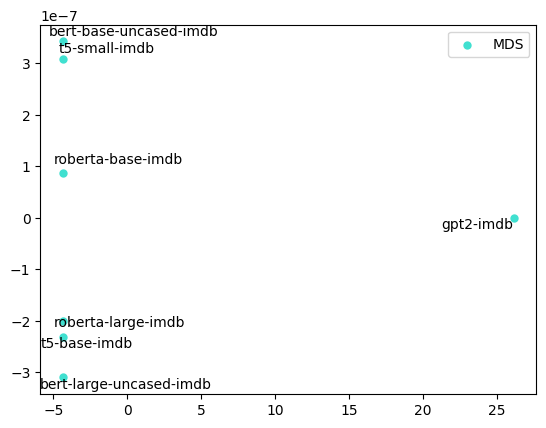

In [29]:
clf = PCA(n_components=2)

pos = clf.fit_transform(pos)

#pos = scaler.fit_transform(pos)

fig, ax = plt.subplots()

ax.scatter(pos[:, 0], pos[:, 1], color="turquoise", lw=0, label="MDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

"""for i, txt in enumerate(MODELS):
    ax.annotate(txt, (pos[i][0], pos[i][1]))"""

texts = []

# Adding labels to data points
for i, txt in enumerate(MODELS):
    if txt == 'TinyLlama-1.1B-Chat-v1.0':
        texts.append(ax.text(pos[i][0], pos[i][1] + 0.3, f"{txt}", fontsize=10, ha='center', va='bottom'))
    else:
        texts.append(ax.text(pos[i][0], pos[i][1], f"{txt}", fontsize=10, ha='center', va='bottom'))

adjust_text(texts)

plt.savefig('mds.pdf')

### Calculate K0 vulnerability

In [223]:
import os

def get_num_files_in_dir(directory_path):
    number_of_files = sum(1 for entry in os.scandir(directory_path) if entry.is_file())

    return number_of_files

# COME BACK HERE TO RECALCULATE VULNERABILITY

In [492]:
from scipy.stats import beta

def get_scores(layer_start = 0.25, layer_end = 0.75, layer=None, MODELS=MODELS):
    vulnerability_scores = []
    
    # for the given delta value, epsilon value, and layer, read the discontinuities
    for m in MODELS:
        num_layers = layer_map[m]
        vulnerability_score = 0
    
        num_layers_processed = 0

        # print(int(layer_start * num_layers), int(layer_end * num_layers), range(int(layer_start * num_layers), int(layer_end * num_layers)))

        it = range(int(layer_start * num_layers), int(layer_end * num_layers))

        if layer_start == layer_end:
            it = [layer_start]
        
        if layer is not None:
            it = [layer]

        if layer == -1:
            it = [num_layers - 1]
        
        for i in it:
            num_layers_processed += 1
            
            file_name = DATA_DIR / f"{m}/L{i}.pth"
            disconts = torch.load(file_name)
    
            # file format for disconts is: 
            # 1000 rows, for each value of delta
            # 15000 columns, one for each data point
            # each item is the min value of epsilon for which it will be a discontinuity
            
            numpy_arrays = [tensor.cpu().numpy().flatten() for tensor in disconts]
    
            matrix = np.asarray(numpy_arrays)
            
            # matrix = np.log1p(matrix)

            #beta_score = beta.pdf(i / num_layers + 1e-2, a=0.5,b=0.5)
            
            vulnerability_score += np.mean(matrix)# * beta_score

            
        
        vulnerability_score /= num_layers_processed
    
        vulnerability_score *= 1000
        
        vulnerability_scores.append((m, vulnerability_score))

    return vulnerability_scores

In [478]:
vulnerability_scores = get_scores(5/6, 1, layer=-1)

In [479]:
vulnerability_scores

[('bert-large-uncased-imdb', 38.58111798763275),
 ('bert-base-uncased-imdb', 55.01098185777664),
 ('roberta-base-imdb', 30.124591663479805),
 ('roberta-large-imdb', 28.620921075344086),
 ('gpt2-imdb', 76.63188129663467),
 ('t5-base-imdb', 74.496790766716),
 ('t5-small-imdb', 68.02471727132797)]

In [344]:
for i in range(6):
    print('--- depths:', i/6, (i+1)/6, '---')
    vulnerability_scores = get_scores(i / 6, (i + 1) / 6)
    print(vulnerability_scores)

--- depths: 0.0 0.16666666666666666 ---
[('bert-large-uncased-imdb', 52.29231342673302), ('bert-base-uncased-imdb', 65.32684899866581), ('roberta-base-imdb', 51.505688577890396), ('roberta-large-imdb', 45.36503925919533), ('gpt2-imdb', 80.2915021777153), ('t5-base-imdb', 74.1000585258007), ('t5-small-imdb', 73.91767203807831), ('TinyLlama-1.1B-Chat-v1.0', 0.000551682035165868)]
--- depths: 0.16666666666666666 0.3333333333333333 ---
[('bert-large-uncased-imdb', 56.54238536953926), ('bert-base-uncased-imdb', 62.706612050533295), ('roberta-base-imdb', 48.02512004971504), ('roberta-large-imdb', 41.22890252619982), ('gpt2-imdb', 90.76803550124168), ('t5-base-imdb', 69.85841691493988), ('t5-small-imdb', 71.97178900241852), ('TinyLlama-1.1B-Chat-v1.0', 0.0004985998387496693)]
--- depths: 0.3333333333333333 0.5 ---
[('bert-large-uncased-imdb', 55.892362259328365), ('bert-base-uncased-imdb', 62.035372480750084), ('roberta-base-imdb', 45.86132988333702), ('roberta-large-imdb', 36.238580010831356

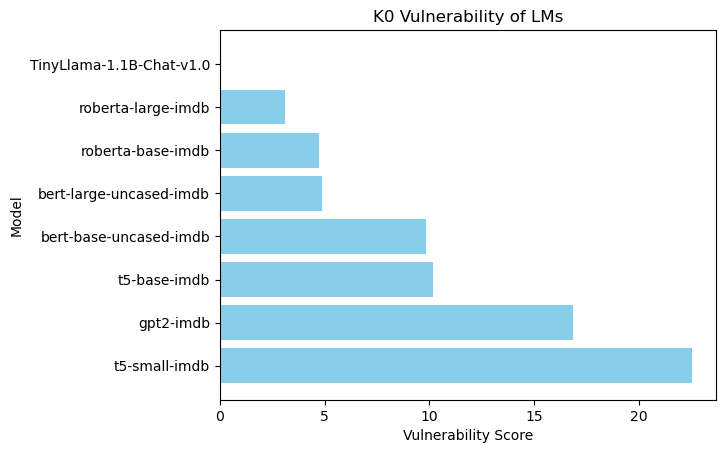

In [227]:
# Sort the data in descending order
sorted_data = sorted(vulnerability_scores, key=lambda x: x[1], reverse=True)
categories, values = zip(*sorted_data)

# Create a bar chart
plt.barh(categories, values, color='skyblue')

# Add labels and a title
plt.xlabel('Vulnerability Score')
plt.ylabel('Model')
plt.title('K0 Vulnerability of LMs')

# Show the plot
plt.show()


In [228]:
log_vulnerability_scores = []

for a, b in vulnerability_scores:
    log_vulnerability_scores.append((a, np.log(b)))

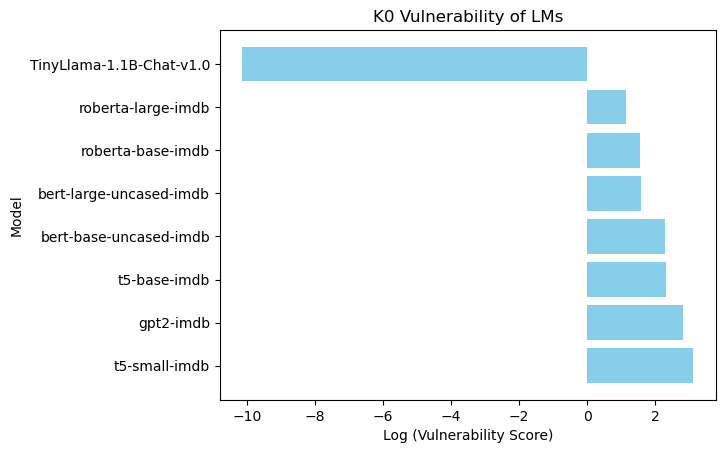

In [229]:
# Sort the data in descending order

sorted_data = sorted(log_vulnerability_scores, key=lambda x: x[1], reverse=True)
categories, values = zip(*sorted_data)

# Create a bar chart
plt.barh(categories, values, color='skyblue')

# Add labels and a title
plt.xlabel('Log (Vulnerability Score)')
plt.ylabel('Model')
plt.title('K0 Vulnerability of LMs')

# Show the plot
plt.show()


### adversarial vulnerability

In [49]:
import pandas as pd

"""
MODELS = [
    "bert-large-uncased-imdb",
    "bert-base-uncased-imdb",
    "roberta-base-imdb",
    "roberta-large-imdb",
    "gpt2-imdb",
    "t5-base-imdb",
    "t5-small-imdb",
    "xlnet-imdb",
    "TinyLlama-1.1B-Chat-v1.0"
]
"""

models = [
    "bert-large-uncased",
    "bert-base-uncased",
    "roberta-base",
    "roberta-large",
    "gpt2",
    "t5-base",
    "t5-small",
]

actual_vulnerability_vectors = []
actual_vulnerability = []

for m in models:
    csv_file = f'../data/adversarial-attacks/tf-{m}.csv'

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    num_success = (df['result_type'] == "Successful").sum()
    actual_vulnerability_vectors.append(df['result_type'] == "Successful")
    
    actual_vulnerability.append((m, num_success))


In [50]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities_actual = euclidean_distances(actual_vulnerability_vectors)

In [51]:
similarities_actual

array([[ 0.        , 67.99264666, 54.95452666, 59.8414572 , 60.34069937,
        66.44546636, 67.90434449],
       [67.99264666,  0.        , 76.41334962, 66.31741853, 67.76429738,
        62.73754857, 61.74139616],
       [54.95452666, 76.41334962,  0.        , 62.44197306, 63.74166612,
        72.43617881, 74.62573283],
       [59.8414572 , 66.31741853, 62.44197306,  0.        , 62.04836823,
        65.32993188, 66.49812027],
       [60.34069937, 67.76429738, 63.74166612, 62.04836823,  0.        ,
        65.51335742, 67.00746227],
       [66.44546636, 62.73754857, 72.43617881, 65.32993188, 65.51335742,
         0.        , 62.67375846],
       [67.90434449, 61.74139616, 74.62573283, 66.49812027, 67.00746227,
        62.67375846,  0.        ]])

In [52]:
actual_similarity_ranks = []

k = 7  # Consider the top 2 most similar elements

# Iterate through each row (or column)
for row in similarities_actual:
  # Sort elements in descending order and get indices
  sorted_indices = row.argsort()[::-1][:k]  # Top k most similar elements
  actual_similarity_ranks.append(sorted_indices.tolist())

# Print the rankings
print(actual_similarity_ranks)

[[1, 6, 5, 4, 3, 2, 0], [2, 0, 4, 3, 5, 6, 1], [1, 6, 5, 4, 3, 0, 2], [6, 1, 5, 2, 4, 0, 3], [1, 6, 5, 2, 3, 0, 4], [2, 0, 4, 3, 1, 6, 5], [2, 0, 4, 3, 5, 1, 6]]


In [60]:
from scipy.stats import spearmanr

avg = 0
cnt = 0
for i in range(7):
    kdi = kd_similarity_ranks[i]
    actuali = actual_similarity_ranks[i]

    spearman_coeff, p_value = spearmanr(kdi, actuali)
    
    print(spearman_coeff)

    avg += spearman_coeff
    cnt += 1

avg /= cnt

print(avg)

0.7142857142857144
0.6785714285714287
-0.21428571428571433
0.7857142857142859
0.4642857142857144
0.42857142857142866
0.3214285714285715
0.4540816326530614


In [339]:
actual_vulnerability

[('bert-large-uncased', 3528),
 ('bert-base-uncased', 6855),
 ('roberta-base', 1958),
 ('roberta-large', 4867),
 ('gpt2', 4467),
 ('t5-base', 5975),
 ('t5-small', 6331)]

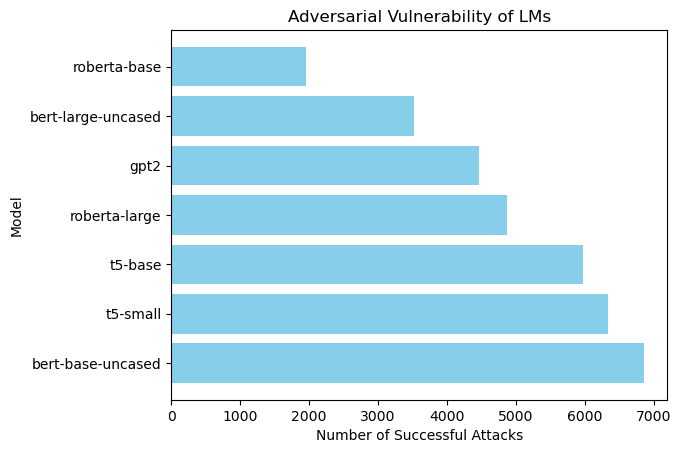

In [52]:
import matplotlib.pyplot as plt

# Sort the data in descending order
sorted_data = sorted(actual_vulnerability, key=lambda x: x[1], reverse=True)
categories, values = zip(*sorted_data)

# Create a bar chart
plt.barh(categories, values, color='skyblue')

# Add labels and a title
plt.xlabel('Number of Successful Attacks')
plt.ylabel('Model')
plt.title('Adversarial Vulnerability of LMs')

# Show the plot
plt.show()


In [53]:
vulnerability_scores = vulnerability_scores[:-2]

In [54]:
actual_vulnerability

[('bert-large-uncased', 3528),
 ('bert-base-uncased', 6855),
 ('roberta-base', 1958),
 ('roberta-large', 4867),
 ('gpt2', 4467),
 ('t5-base', 5975),
 ('t5-small', 6331)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


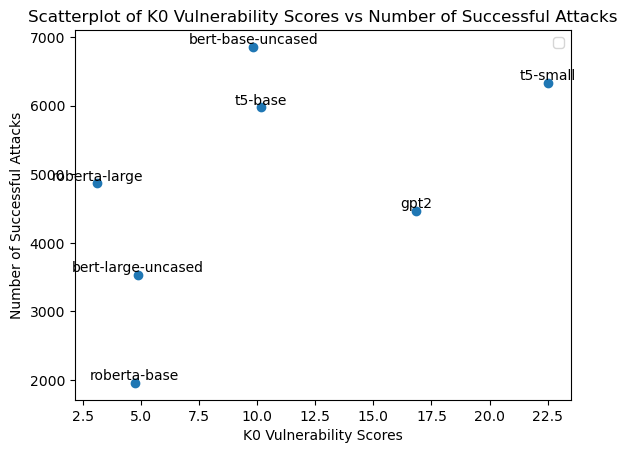

In [55]:
# Create the scatterplot
plt.scatter([value for _, value in vulnerability_scores], [value for _, value in actual_vulnerability], marker='o')

# Customize the plot
plt.title('Scatterplot of K0 Vulnerability Scores vs Number of Successful Attacks')
plt.xlabel('K0 Vulnerability Scores')
plt.ylabel('Number of Successful Attacks')
#plt.grid(True)
plt.legend()

# Adding labels to data points
for i, txt in enumerate(models):
    plt.text(vulnerability_scores[i][1], actual_vulnerability[i][1], f"{txt}", fontsize=10, ha='center', va='bottom')

plt.savefig('k0vuln_vs_attack.pdf')

In [474]:
actual_vulnerability

[('bert-large-uncased', 3528),
 ('bert-base-uncased', 6855),
 ('roberta-base', 1958),
 ('roberta-large', 4867),
 ('gpt2', 4467),
 ('t5-base', 5975),
 ('t5-small', 6331)]

In [475]:
vulnerability_scores

[('bert-large-uncased-imdb', 42.749651707708836),
 ('bert-base-uncased-imdb', 54.03298884630203),
 ('roberta-base-imdb', 29.055326245725155),
 ('roberta-large-imdb', 25.689239613711834),
 ('gpt2-imdb', 82.57335796952248),
 ('t5-base-imdb', 70.78373804688454),
 ('t5-small-imdb', 68.02471727132797)]

38.58111798763275 , 3528 , bert-large-uncased
55.01098185777664 , 6855 , bert-base-uncased
30.124591663479805 , 1958 , roberta-base
28.620921075344086 , 4867 , roberta-large
76.63188129663467 , 4467 , gpt2
74.496790766716 , 5975 , t5-base
68.02471727132797 , 6331 , t5-small


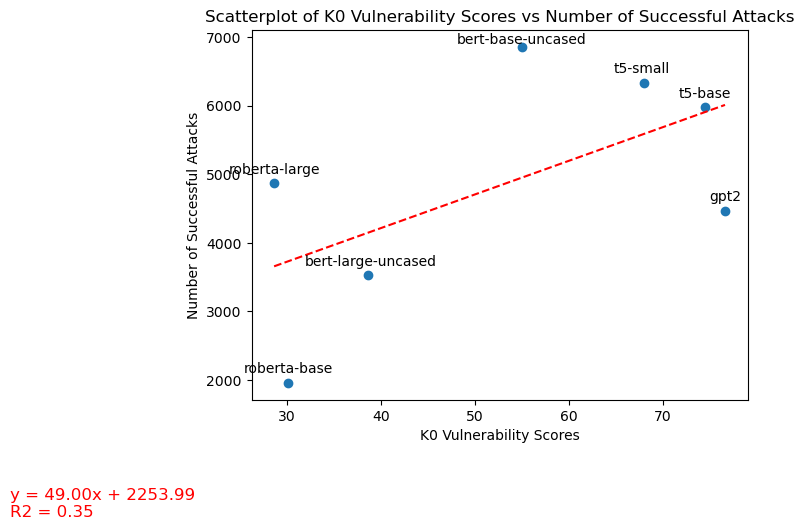

In [481]:
from scipy import stats

# Create the scatterplot
x = np.asarray([value for _, value in vulnerability_scores])
y = np.asarray([value for _, value in actual_vulnerability])
plt.scatter(x, y, marker='o')

for i in range(7):
    print(x[i], ',', y[i], ',', models[i])
    
# Customize the plot
plt.title('Scatterplot of K0 Vulnerability Scores vs Number of Successful Attacks')
plt.xlabel('K0 Vulnerability Scores')
plt.ylabel('Number of Successful Attacks')

# Adding labels to data points
for i, txt in enumerate(models):
    delta = 0
    deltaY = 0
    if txt == 'roberta-large':
        # delta += 1.5
        delta = 0
    if txt == 'bert-large-uncased':
        delta += 0.3
    if txt == 't5-small':
        delta -= 0.3
    if txt == 'bert-base-uncased':
        deltaY -= 100
    plt.text(vulnerability_scores[i][1] + delta, actual_vulnerability[i][1] + 100 + deltaY, f"{txt}", fontsize=10, ha='center', va='bottom')

# Perform linear regression to get the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Label the line with the equation and R-squared value
equation = f'y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_squared:.2f}'
plt.text(0.5, 3, equation, fontsize=12, color='r')

# Plot the line of best fit
x_line = np.linspace(min(x), max(x))
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='r', linestyle='--')

plt.savefig('k0vuln_vs_attack_with_line_no_gpt2.pdf')

In [482]:
X = [38.5811179, 55.0109818, 30.124591, 28.620921, 74.496790, 68.024717]
y = [3528, 6855, 1958, 4867, 5975, 6331]

slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

# Calculate the R-squared value
r_squared = r_value ** 2

In [483]:
print(slope, intercept, r_squared)

70.98274702213037 1430.6816283582648 0.5531925136712629


In [261]:
vulnerability_scores

[('bert-large-uncased-imdb', 1.6075465828180313),
 ('bert-base-uncased-imdb', 4.584248488148053),
 ('roberta-base-imdb', 2.5103826386233172),
 ('roberta-large-imdb', 1.1925383781393368),
 ('gpt2-imdb', 6.38599010805289),
 ('t5-base-imdb', 6.208065897226334),
 ('t5-small-imdb', 11.337452878554663)]

In [238]:
actual_vulnerability

[('bert-large-uncased', 3528),
 ('bert-base-uncased', 6855),
 ('roberta-base', 1958),
 ('roberta-large', 4867),
 ('gpt2', 4467),
 ('t5-base', 5975),
 ('t5-small', 6331)]

## Test for best R2

In [58]:
from scipy import stats

values = [
    # ranges
    (0.25, 0.75),
    (0.5, 0.5),
    # individual layers
    (0, 0.0834),
    (0.0834, 0.1667),
    (0.1667, 0.25),
    (0.25, 0.34),
    (0.33, 0.417),
    (0.417, 0.5),
    (0.5, 0.583),
    (0.583, 0.667),
    (0.666, 0.75),
    (0.666, 0.834),
    (0.833, 0.917),
    (0.917, 1.000),
]

best = []

for start, end in values:
    try:
        vulnerability_scores = get_scores(start, end)[:-2]
    except:
        continue
    
    # Create the scatterplot
    x = np.asarray([value for _, value in vulnerability_scores])
    y = np.asarray([value for _, value in actual_vulnerability])
    
    # Perform linear regression to get the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Calculate the R-squared value
    r_squared = r_value ** 2

    best.append((r_squared, start, end))

best.sort()

best

[(0.08765407961954069, 0.417, 0.5),
 (0.0896052553317741, 0.25, 0.34),
 (0.1816980657754464, 0.0834, 0.1667),
 (0.1861210825534718, 0.33, 0.417),
 (0.2209382113575256, 0.583, 0.667),
 (0.25901481371154533, 0.666, 0.75),
 (0.2625877732825811, 0.25, 0.75),
 (0.26688786762105915, 0.666, 0.834),
 (0.27643897965154174, 0.833, 0.917),
 (0.3049597234067324, 0.917, 1.0)]

In [333]:
# individual values
values = [0, 0.25, 0.5, 0.75, 1]
for i in range(1, 12):
    values.append(i / 12)

values.sort()

for i in range(len(values)):
    for j in range(i, len(values)):
        start = values[i]
        end = values[j]

        try:
            vulnerability_scores = get_scores(start, end)[:-1]
        except:
            continue
    
        # Create the scatterplot
        x = np.asarray([value for _, value in vulnerability_scores])
        y = np.asarray([value for _, value in actual_vulnerability])
        
        # Perform linear regression to get the line of best fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Calculate the R-squared value
        r_squared = r_value ** 2
    
        best.append((r_squared, start, end))
    
best.sort()

In [334]:
best

[(0.05033879652691235, 0.3333333333333333, 0.5),
 (0.05033879652691235, 0.3333333333333333, 0.5),
 (0.05268309038388351, 0.25, 0.5),
 (0.05268309038388351, 0.25, 0.5),
 (0.05268309038388351, 0.25, 0.5),
 (0.05268309038388351, 0.25, 0.5),
 (0.053314287682999326, 0.3333333333333333, 0.5833333333333334),
 (0.05356177179865318, 0.25, 0.4166666666666667),
 (0.05356177179865318, 0.25, 0.4166666666666667),
 (0.05386032851956026, 0.4166666666666667, 0.5),
 (0.05386032851956026, 0.4166666666666667, 0.5),
 (0.05436006224526722, 0.25, 0.3333333333333333),
 (0.05436006224526722, 0.25, 0.3333333333333333),
 (0.05510962861291282, 0.25, 0.5833333333333334),
 (0.05510962861291282, 0.25, 0.5833333333333334),
 (0.05660589753017026, 0.4166666666666667, 0.5833333333333334),
 (0.05897285376345178, 0.3333333333333333, 0.6666666666666666),
 (0.05929552147888645, 0.25, 0.6666666666666666),
 (0.05929552147888645, 0.25, 0.6666666666666666),
 (0.06409341926199541, 0.4166666666666667, 0.6666666666666666),
 (0.067

X: [0.3333333333333333, 0.3333333333333333, 0.4166666666666667, 0.5, 0.5, 0.5833333333333334, 0.5833333333333334, 0.16666666666666666, 0.75, 0.75, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.4166666666666667, 0.5, 0.5, 0, 0.08333333333333333, 0.08333333333333333, 0.5833333333333334, 0.5833333333333334, 0.8333333333333334, 0, 0.75, 0.75, 0.08333333333333333, 0.08333333333333333, 0.8333333333333334, 0.3333333333333333, 0.3333333333333333, 0.4166666666666667, 0.5, 0.5, 0.16666666666666666, 0.08333333333333333, 0.08333333333333333, 0.75, 0.75, 0.5833333333333334, 0.5833333333333334, 0, 0.8333333333333334]
y: [0.05033879652691235, 0.05033879652691235, 0.05660589753017026, 0.06728955112006166, 0.06728955112006166, 0.10332966836847068, 0.10332966836847068, 0.12909187726710145, 0.1731865971725579, 0.1731865971725579, 0.1878381377199879, 0.1878381377199879, 0.1888114342616131, 0.2001005601171731, 0.22681749515036506, 0.22681749515036506, 0.237320383928085, 0.24660534925465083

'\nThis justifies empirically our beta curve\nPoints at higher relative depth are more important\n(And to some extent points at the beginning as well)\n'

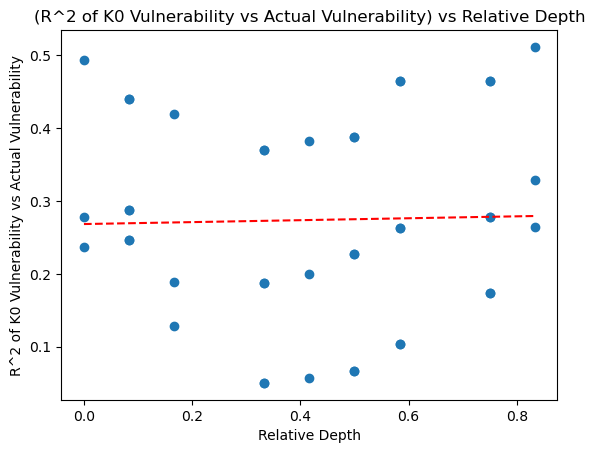

In [335]:
best_filtered = []

for r2, s, e in best:
    if e == s + 1/6:
        best_filtered.append((r2, s, e))

def plot():
    X = []
    y = []

    for r2, s, e in best_filtered:
        X.append(s)
        y.append(r2)

    print('X:', X)
    print('y:', y)
    
    print(len(X), len(y))
    
    plt.scatter(X, y, marker='o')
    
    # Customize the plot
    plt.title('(R^2 of K0 Vulnerability vs Actual Vulnerability) vs Relative Depth')
    plt.xlabel('Relative Depth')
    plt.ylabel('R^2 of K0 Vulnerability vs Actual Vulnerability')
    
    # Perform linear regression to get the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    
    # Calculate the R-squared value
    r_squared = r_value ** 2
    
    # Label the line with the equation and R-squared value
    equation = f'y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_squared:.2f}'
    #plt.text(0.5, 3, equation, fontsize=12, color='r')
    
    # Plot the line of best fit
    x_line = np.linspace(min(X), max(X))
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, color='r', linestyle='--')
    
    plt.savefig('depth_vs_r2.pdf')

plot()

"""
This justifies empirically our beta curve
Points at higher relative depth are more important
(And to some extent points at the beginning as well)
"""

X: [0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.4166666666666667, 0.5, 0.5, 0, 0.08333333333333333, 0.08333333333333333, 0.5833333333333334, 0.5833333333333334, 0.75, 0.75, 0.8333333333333334]
y: [0.1878381377199879, 0.1878381377199879, 0.1888114342616131, 0.2001005601171731, 0.22681749515036506, 0.22681749515036506, 0.237320383928085, 0.24660534925465083, 0.24660534925465083, 0.2625877732825811, 0.2625877732825811, 0.2785487308817123, 0.2785487308817123, 0.3285176801803941]
14 14


'\nThis justifies empirically our beta curve\nPoints at higher relative depth are more important\n(And to some extent points at the beginning as well)\n'

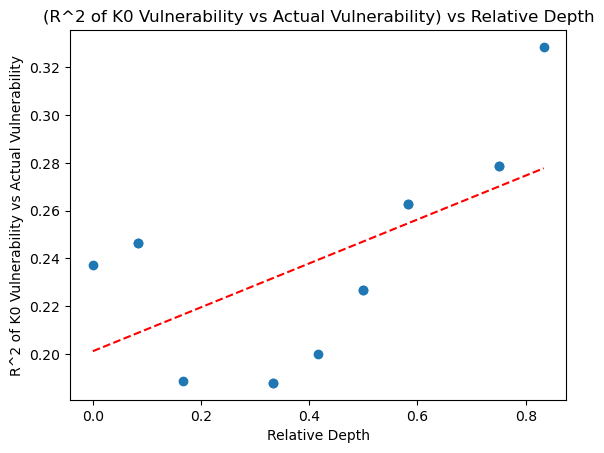

In [253]:
best_filtered = []

for r2, s, e in best:
    if e == s + 1/6:
        best_filtered.append((r2, s, e))

def plot():
    X = []
    y = []

    for r2, s, e in best_filtered:
        X.append(s)
        y.append(r2)

    print('X:', X)
    print('y:', y)
    
    print(len(X), len(y))
    
    plt.scatter(X, y, marker='o')
    
    # Customize the plot
    plt.title('(R^2 of K0 Vulnerability vs Actual Vulnerability) vs Relative Depth')
    plt.xlabel('Relative Depth')
    plt.ylabel('R^2 of K0 Vulnerability vs Actual Vulnerability')
    
    # Perform linear regression to get the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    
    # Calculate the R-squared value
    r_squared = r_value ** 2
    
    # Label the line with the equation and R-squared value
    equation = f'y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_squared:.2f}'
    #plt.text(0.5, 3, equation, fontsize=12, color='r')
    
    # Plot the line of best fit
    x_line = np.linspace(min(X), max(X))
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, color='r', linestyle='--')
    
    plt.savefig('depth_vs_r2.pdf')

plot()

"""
This justifies empirically our beta curve
Points at higher relative depth are more important
(And to some extent points at the beginning as well)
"""

## R^2 vs vulnerability

In [499]:
MODELS

['bert-large-uncased-imdb',
 'bert-base-uncased-imdb',
 'roberta-base-imdb',
 'roberta-large-imdb',
 'gpt2-imdb',
 't5-base-imdb',
 't5-small-imdb']

X: [0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334]
y: [0.41701885825979446, 0.3736832683723828, 0.40451081086739005, 0.4236100326881248, 0.4754584225111333, 0.5531925016900412]
6 6


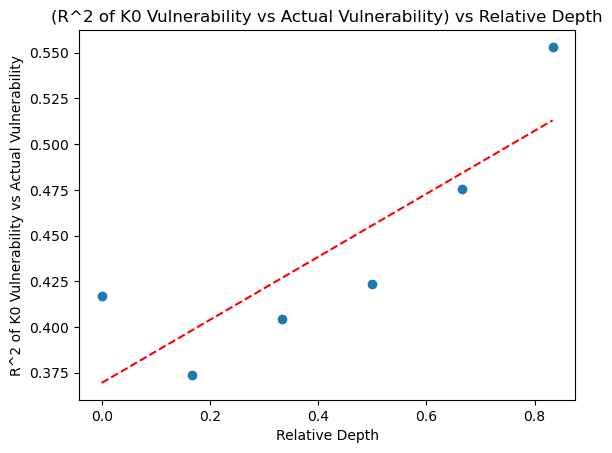

In [502]:
def plot():
    X = []
    y = []

    for i in range(6):
        scores = get_scores((i + 1) / 6 - 1/24, (i + 1) / 6)

        x = [value for _, value in scores]
        Y = [value for _, value in actual_vulnerability]

        x = x[:4] + x[5:]
        Y = Y[:4] + Y[5:]

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, Y)
    
        # Calculate the R-squared value
        r_squared = r_value ** 2
                            
        X.append(i / 6)
        y.append(r_squared)

    print('X:', X)
    print('y:', y)
    
    print(len(X), len(y))
    
    plt.scatter(X, y, marker='o')
    
    # Customize the plot
    plt.title('(R^2 of K0 Vulnerability vs Actual Vulnerability) vs Relative Depth')
    plt.xlabel('Relative Depth')
    plt.ylabel('R^2 of K0 Vulnerability vs Actual Vulnerability')
    
    # Perform linear regression to get the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    
    # Calculate the R-squared value
    r_squared = r_value ** 2
    
    # Label the line with the equation and R-squared value
    equation = f'y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_squared:.2f}'
    #plt.text(0.5, 3, equation, fontsize=12, color='r')
    
    # Plot the line of best fit
    x_line = np.linspace(min(X), max(X))
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, color='r', linestyle='--')
    
    plt.savefig('depth_vs_r2.pdf')

plot()

## HI

--- bert-large-uncased-imdb ---
24
0 0.0 0.041666666666666664
1 0.041666666666666664 0.08333333333333333
2 0.08333333333333333 0.125
3 0.125 0.16666666666666666
4 0.16666666666666666 0.20833333333333331
5 0.20833333333333334 0.25
6 0.25 0.2916666666666667
7 0.2916666666666667 0.33333333333333337
8 0.3333333333333333 0.375
9 0.375 0.4166666666666667
10 0.4166666666666667 0.45833333333333337
11 0.4583333333333333 0.5
12 0.5 0.5416666666666666
13 0.5416666666666666 0.5833333333333333
14 0.5833333333333334 0.625
15 0.625 0.6666666666666666
16 0.6666666666666666 0.7083333333333333
17 0.7083333333333334 0.75
18 0.75 0.7916666666666666
19 0.7916666666666666 0.8333333333333333
20 0.8333333333333334 0.875
21 0.875 0.9166666666666666
22 0.9166666666666666 0.9583333333333333
23 0.9583333333333334 1.0
--- bert-base-uncased-imdb ---
12
0 0.0 0.08333333333333333
1 0.08333333333333333 0.16666666666666666
2 0.16666666666666666 0.25
3 0.25 0.3333333333333333
4 0.3333333333333333 0.41666666666666663
5 0

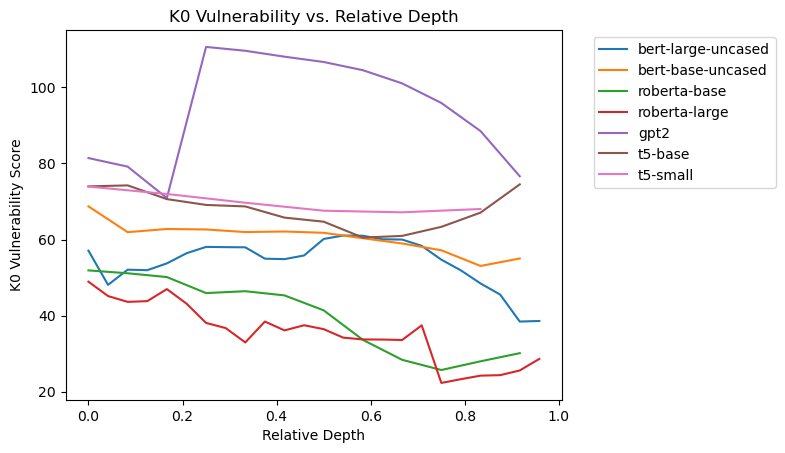

<Figure size 1000x600 with 0 Axes>

In [491]:


def calc():
    total_text = ''
    
    for i, m in enumerate(MODELS):
        print('---', m, '---')
        print(num_layers[i])
        
        X = []
        y = []

        l = num_layers[i]

        for s in range(l):
            print(s, s/l, s/l + 1/l)
            X.append(s / l)
            score = get_scores(layer=s, MODELS=[m])[0][1]
            y.append(score)

        #print('X', X)
        #print('y', y)

        lab = m

        if lab.endswith('-imdb'):
            lab = lab[:-5]
        
        plt.plot(X, y, label=lab)

        for i in range(len(X)):
            total_text += str(X[i]) + ',' + str(y[i]) + ',' + lab + '\n'

        plt.xlabel('Relative Depth')
        plt.ylabel('K0 Vulnerability Score')
        plt.title(f'K0 Vulnerability vs. Relative Depth')

        plt.legend()

    print('------------------')
    print(total_text)
calc()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(10, 6))  # Change width and height as needed
plt.savefig('vuln_score vs relative_depth.pdf')

--- bert-large-uncased-imdb ---
24
0 0.0 0.041666666666666664
1 0.041666666666666664 0.08333333333333333
2 0.08333333333333333 0.125
3 0.125 0.16666666666666666
4 0.16666666666666666 0.20833333333333331
5 0.20833333333333334 0.25
6 0.25 0.2916666666666667
7 0.2916666666666667 0.33333333333333337
8 0.3333333333333333 0.375
9 0.375 0.4166666666666667
10 0.4166666666666667 0.45833333333333337
11 0.4583333333333333 0.5
12 0.5 0.5416666666666666
13 0.5416666666666666 0.5833333333333333
14 0.5833333333333334 0.625
15 0.625 0.6666666666666666
16 0.6666666666666666 0.7083333333333333
17 0.7083333333333334 0.75
18 0.75 0.7916666666666666
19 0.7916666666666666 0.8333333333333333
20 0.8333333333333334 0.875
21 0.875 0.9166666666666666
22 0.9166666666666666 0.9583333333333333
23 0.9583333333333334 1.0
--- bert-base-uncased-imdb ---
12
0 0.0 0.08333333333333333
1 0.08333333333333333 0.16666666666666666
2 0.16666666666666666 0.25
3 0.25 0.3333333333333333
4 0.3333333333333333 0.41666666666666663
5 0

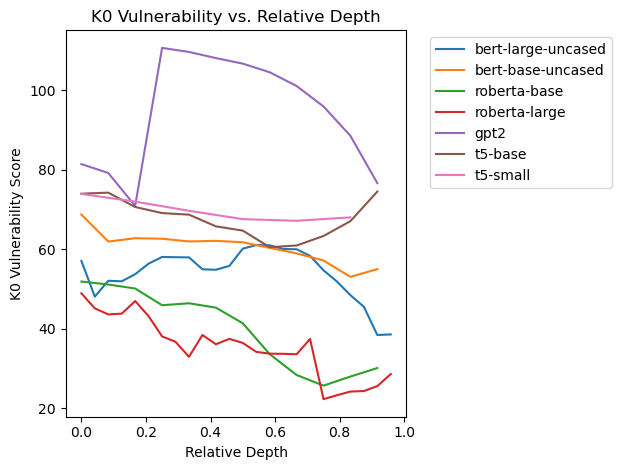

In [319]:
calc()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('vuln_score vs relative_depth.pdf')

In [ ]:
## vulnerability score vs relative depth for each model
## log scores and find R^2

## Gen confusion matrix

In [319]:
delta = 0.3
epsilon = 0.01
layer = 13

X = []

# for the given delta value, epsilon value, and layer, read the discontinuities
for m in MODELS:
    file_name = DATA_DIR / f"{m}/L{layer - 1}.pth"
    disconts = torch.load(file_name)
    
    # file format for disconts is: 
    # 1000 rows, for each value of delta
    # 15000 columns, one for each data point
    # each item is the min value of epsilon for which it will be a discontinuity
    
    row_idx = int(delta * 1000)
    
    ret = []
    
    row = disconts[row_idx].detach().cpu().numpy()
    
    ret = np.where(row > epsilon, 1, 0)
    
    X.append(ret)

X = np.asarray(X)

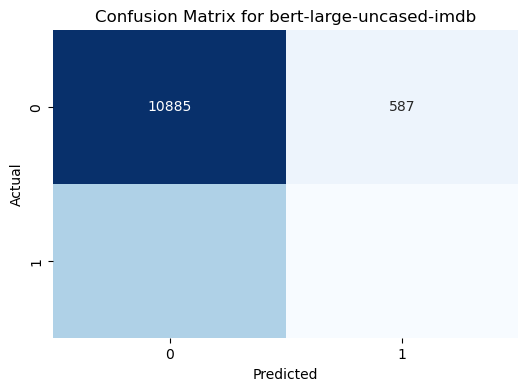

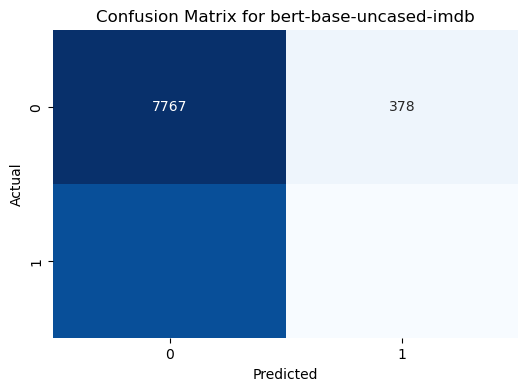

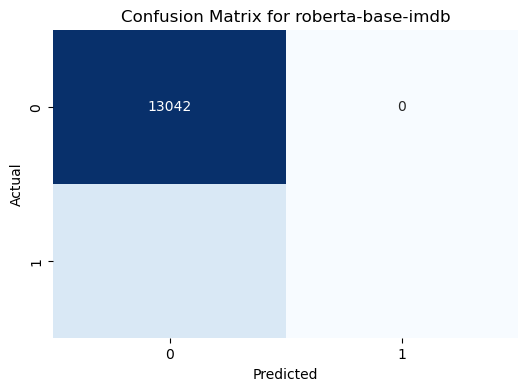

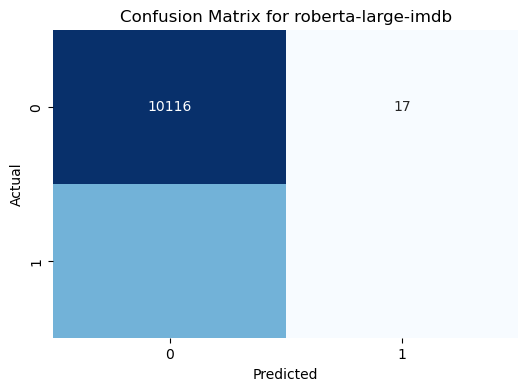

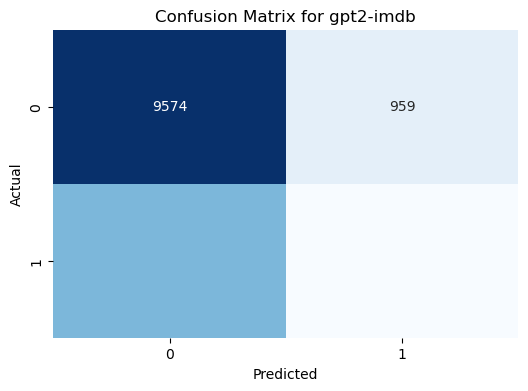

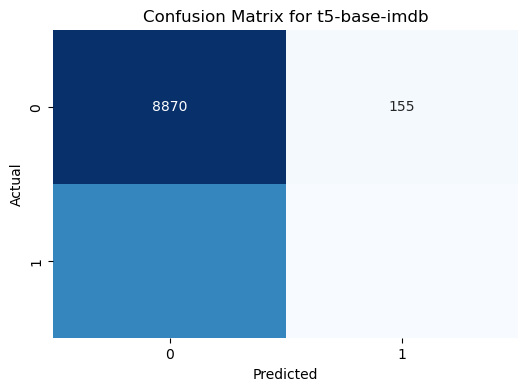

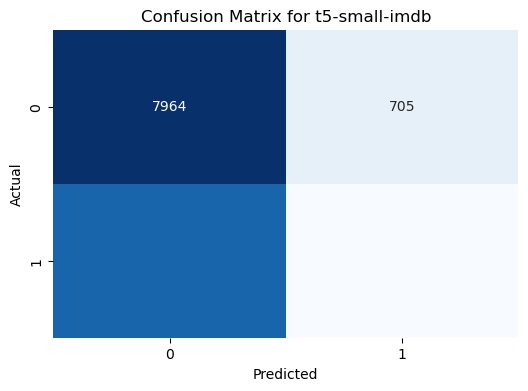

FileNotFoundError: [Errno 2] No such file or directory: '../data/adversarial-attacks/tf-xlnet-base-cased.csv'

In [234]:
models = [
    "bert-large-uncased",
    "bert-base-uncased",
    "roberta-base",
    "roberta-large",
    "gpt2",
    "t5-base",
    "t5-small",
    "xlnet-base-cased",
    "xlnet-base-not-finetuned",
    "TinyLlama-1.1B-Chat-v1.0"
]

from sklearn.metrics import confusion_matrix
import seaborn as sns

for i in range(len(MODELS)):
    csv_file = f'../data/adversarial-attacks/tf-{models[i]}.csv'

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    actual_arr = (df['result_type'] == "Successful")
    
    conf_matrix = confusion_matrix(actual_arr, X[i])
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {MODELS[i]}')
    plt.show()

## sort vulnerability score by size and stuff

In [ ]:
!pip install --upgrade ipywidgets
!pip3 install tqdm==4.40.0

In [235]:
"""from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
num_params = model.num_parameters()
print(f"Number of parameters: {num_params}")"""

'from transformers import AutoModelForSequenceClassification\n\nmodel = AutoModelForSequenceClassification.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")\nnum_params = model.num_parameters()\nprint(f"Number of parameters: {num_params}")'

In [71]:
sizes = {'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 't5-base': 223495682, 't5-small': 60770306, 'xlnet-base-cased': 117310466, 'xlnet-base-not-finetuned': 117310466, 'TinyLlama-1.1B-Chat-v1.0': 1034516480}

def get_size(name):
    if name.endswith('-imdb'):
        name = name[:-5]
    
    return sizes[name]

[('t5-small-imdb', 22.525183856487274), ('bert-base-uncased-imdb', 9.826681266228357), ('gpt2-imdb', 16.842439770698547), ('roberta-base-imdb', 4.729464650154114), ('t5-base-imdb', 10.15869714319706), ('bert-large-uncased-imdb', 4.860984161496162), ('roberta-large-imdb', 3.1195388485987983), ('TinyLlama-1.1B-Chat-v1.0', 3.947470035696328e-05)]


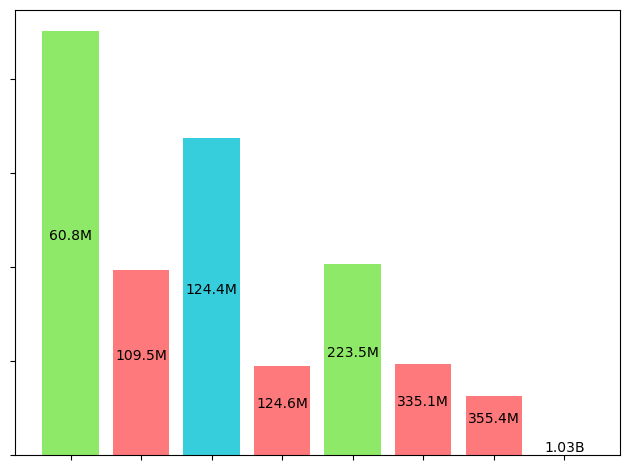

In [234]:
from matplotlib.patches import Patch

# Sort the zipped data based on the third variable
sorted_data = sorted(vulnerability_scores, key=lambda x: get_size(x[0]))

#{'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 
# 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 
# 't5-base': 223495682, 't5-small': 60770306}

sorted_x_values = []
sorted_bar_heights = []

for i in sorted_data:
    sorted_x_values.append(i[0])
    if sorted_x_values[-1].endswith('-imdb'):
        sorted_x_values[-1] = sorted_x_values[-1][:-5]
    sorted_bar_heights.append(i[1])

print(sorted_data)

bar_colors = ['#8FE968', '#FE797B', '#36CEDC', '#FE797B', '#8FE968', '#FE797B', '#FE797B', '#36CEDC']
meaning = {
    '#8FE968': 'encoder-decoder',
    '#FE797B': 'encoder-only',
    '#36CEDC': 'decoder-only'
}

# Create the bar chart
bars = plt.bar(sorted_x_values, sorted_bar_heights, color=bar_colors)

# Label the axes
#plt.xlabel('Models (sorted in ascending order of size)')
#plt.ylabel('K0 Vulnerability Score')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=70)

# Create a list of proxy artists for the legend
legend_elements = [Patch(facecolor=color, label=meaning[color]) for color in np.unique(bar_colors)]

# Create a legend with proxy artists
# plt.legend(handles=legend_elements, title='Color Legend', loc='upper right')

# Add labels on top of each bar
for x, y in zip(sorted_x_values, sorted_bar_heights):
    if get_size(x) < 1e9:
        plt.text(x, y / 2, f'{get_size(x) / 1e6:.1f}M', ha='center', va='bottom')
    else:
        plt.text(x, y / 2, f'{get_size(x) / 1e9:.2f}B', ha='center', va='bottom')

# Remove y-axis labels
plt.tick_params(axis='y', labelleft=False)

# Remove x-axis labels
plt.tick_params(axis='x', labelbottom=False)

plt.tight_layout()

# Show the plot
plt.savefig('k0_by_size_blank.pdf')

#### scatterplot of size vs k0 vulnerability

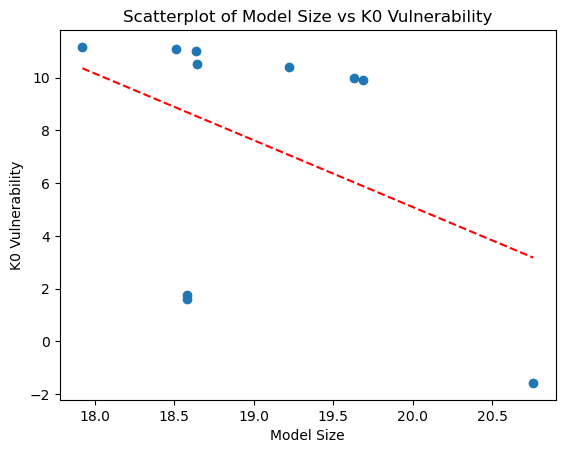

In [238]:
from scipy import stats

# Create the scatterplot
x = np.log(np.asarray([get_size(model) for model, value in vulnerability_scores]))
y = np.log(np.asarray([value for _, value in vulnerability_scores]))
plt.scatter(x, y, marker='o')

# Customize the plot
plt.title('Scatterplot of Model Size vs K0 Vulnerability')
plt.xlabel('Model Size')
plt.ylabel('K0 Vulnerability')

# Perform linear regression to get the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Label the line with the equation and R-squared value
equation = f'y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_squared:.2f}'
#plt.text(0.5, 3, equation, fontsize=12, color='r')

# Plot the line of best fit
x_line = np.linspace(min(x), max(x))
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='r', linestyle='--')

plt.savefig('size_vs_k0.pdf')

### correlation matrix between all models

In [506]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [240]:
def jaccard_similarity(vector1, vector2):
    #intersection = np.sum(np.logical_or(np.logical_and(vector1, vector2), np.logical_and(~vector1, ~vector2)))
    intersection = np.sum(vector1 == vector2)
    union = max(len(vector1), len(vector2))
    
    jaccard_coefficient = intersection / union if union != 0 else 0
    return jaccard_coefficient

In [738]:
def dice_coefficient(vector1, vector2):
    intersection = 2 * np.sum(vector1 == vector2)
    union = len(vector1) + len(vector2)
    
    dice_coefficient = intersection / union if union != 0 else 0
    return dice_coefficient

In [739]:
from scipy.stats import pointbiserialr

correlation_matrix = np.zeros((7,7))
p_value_matrix = np.zeros((7,7))

for i in range(7):
    for j in range(7):
        # Calculate the point-biserial correlation coefficient
        #correlation, p_value = pointbiserialr(X[i], X[j])
        # correlation = jaccard_similarity(X[i], X[j])
        
        #correlation_matrix[i][j] = correlation
        #p_value_matrix[i][j] = p_value

        correlation_matrix[i][j] = dice_coefficient(X[i], X[j])

In [740]:
correlation_matrix

array([[1.        , 0.9582    , 0.95793333, 0.952     , 0.94273333,
        0.9536    , 0.94593333],
       [0.9582    , 1.        , 0.9692    , 0.9578    , 0.94173333,
        0.97033333, 0.96266667],
       [0.95793333, 0.9692    , 1.        , 0.9634    , 0.94306667,
        0.97073333, 0.9588    ],
       [0.952     , 0.9578    , 0.9634    , 1.        , 0.9398    ,
        0.96746667, 0.95006667],
       [0.94273333, 0.94173333, 0.94306667, 0.9398    , 1.        ,
        0.94286667, 0.93786667],
       [0.9536    , 0.97033333, 0.97073333, 0.96746667, 0.94286667,
        1.        , 0.96646667],
       [0.94593333, 0.96266667, 0.9588    , 0.95006667, 0.93786667,
        0.96646667, 1.        ]])

In [744]:
with open('correlation_matrix.pickle', 'wb') as f:
    pickle.dump(correlation_matrix, f)

In [534]:
np.savetxt('heatmap.csv', correlation_matrix, delimiter=',')

In [243]:
models

['bert-large-uncased',
 'bert-base-uncased',
 'roberta-base',
 'roberta-large',
 'gpt2',
 't5-base',
 't5-small',
 'xlnet-base-cased',
 'xlnet-base-not-finetuned',
 'TinyLlama-1.1B-Chat-v1.0']

In [733]:
!pip install matplotlib==3.7.3

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.7.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.7 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached matplotlib-3.7.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.4
    Uninstalling matplotlib-3.7.4:
      Successfully uninstalled matplotlib-3.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bert-score 0.3.13 requires tqdm>=4.31.1, which is not installed.
bpemb 0.3.4 requires tqdm, which is not installed.
flair 0.11.3 requires huggingface-hub, which is not installed.
f

In [742]:
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.0
    Uninstalling seaborn-0.13.0:
      Successfully uninstalled seaborn-0.13.0


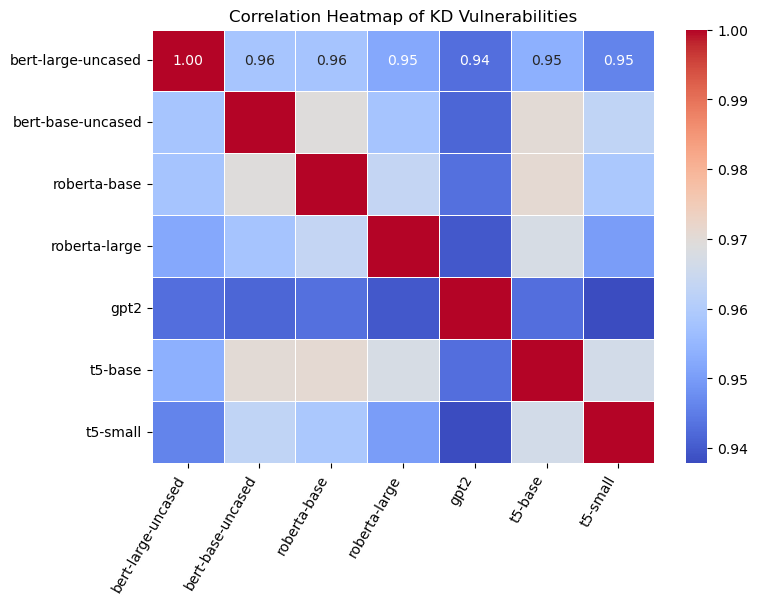

In [743]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set row and column labels
heatmap.set_xticklabels(models, rotation=60, ha='right')
heatmap.set_yticklabels(models, rotation=0)

plt.tight_layout()

plt.title("Correlation Heatmap of KD Vulnerabilities")
plt.savefig('k0_vulnerabilities_correlation_heatmap.pdf')

All correlations seem to be positive...

Min correlation is 0.36

In [536]:
MODELS

['bert-large-uncased-imdb',
 'bert-base-uncased-imdb',
 'roberta-base-imdb',
 'roberta-large-imdb',
 'gpt2-imdb',
 't5-base-imdb',
 't5-small-imdb']

## Linear regression

In [1]:
from sklearn.linear_model import HuberRegressor, LinearRegression

In [134]:
MODELS = [
    "bert-large-uncased-imdb",
    "bert-base-uncased-imdb",
    "roberta-base-imdb",
    "roberta-large-imdb",
    "gpt2-imdb",
    "t5-base-imdb",
    "t5-small-imdb",
    "xlnet-imdb",
    "TinyLlama-1.1B-Chat-v1.0"
]

In [364]:
vulnerability_scores = vulnerability_scores[:-1]

vulnerability_scores

[('bert-large-uncased-imdb', 54.044245121379696),
 ('bert-base-uncased-imdb', 60.535915195941925),
 ('roberta-base-imdb', 39.830736660708986),
 ('roberta-large-imdb', 35.36518228550752),
 ('gpt2-imdb', 94.42467118302982),
 ('t5-base-imdb', 67.78534067173798),
 ('t5-small-imdb', 69.71932078401248)]

In [429]:
n = len(MODELS) - 1

X = [[] for i in range(n)]

y = [score for _, score in vulnerability_scores]

In [430]:
# add features to X

# num layers
for i in range(n):
    X[i].append(num_layers[i])

# architecture type
# encoder = first, decoder = second, encoder-decoder
X[0].extend([1, 0, 0])
X[1].extend([1, 0, 0])
X[2].extend([1, 0, 0])
X[3].extend([1, 0, 0])
X[4].extend([0, 1, 0])
X[5].extend([0, 0, 1]) # change encoder-decoder to 0,0,1
X[6].extend([0, 0, 1])
#X[7].extend([0, 1, 0])
#X[8].extend([0, 1, 0])

# model size
sizes = {'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 't5-base': 223495682, 't5-small': 60770306, 'xlnet-base-cased': 117310466, 'xlnet-base-not-finetuned': 117310466, 'TinyLlama-1.1B-Chat-v1.0': 1034516480}
sizes_list = [
    335143938,
    109483778,
    124647170,
    355361794,
    124441344,
    223495682,
    60770306,
    117310466,
    1034516480
]

print(MODELS)

for i in range(n):
    X[i].append(sizes_list[i])

# log model size
import math


for i in range(n):
    X[i].append(math.log(sizes_list[i]))

# training set size -- can't do rn
"""
X[0].append()
X[1].append() # 
X[2].append() #
X[3].append() #
X[4].append(8e6) # https://huggingface.co/transformers/v2.11.0/model_doc/gpt2.html
X[5].append() #
X[6].append() #
X[7].append() #
"""

X

['bert-large-uncased-imdb', 'bert-base-uncased-imdb', 'roberta-base-imdb', 'roberta-large-imdb', 'gpt2-imdb', 't5-base-imdb', 't5-small-imdb', 'TinyLlama-1.1B-Chat-v1.0']


[[24, 1, 0, 0, 335143938, 19.63007066318112],
 [12, 1, 0, 0, 109483778, 18.51128695012739],
 [12, 1, 0, 0, 124647170, 18.640997664106116],
 [24, 1, 0, 0, 355361794, 19.68864696649927],
 [12, 0, 1, 0, 124441344, 18.639345030321113],
 [12, 0, 0, 1, 223495682, 19.22490265192075],
 [6, 0, 0, 1, 60770306, 17.922611839478158]]

In [431]:
#for i in range(len(X)):
#    X[i] = np.asarray(X[i])

X = np.array(X)
y = np.asarray(y)

print(X.shape)
print(X)

(7, 6)
[[2.40000000e+01 1.00000000e+00 0.00000000e+00 0.00000000e+00
  3.35143938e+08 1.96300707e+01]
 [1.20000000e+01 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.09483778e+08 1.85112870e+01]
 [1.20000000e+01 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.24647170e+08 1.86409977e+01]
 [2.40000000e+01 1.00000000e+00 0.00000000e+00 0.00000000e+00
  3.55361794e+08 1.96886470e+01]
 [1.20000000e+01 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.24441344e+08 1.86393450e+01]
 [1.20000000e+01 0.00000000e+00 0.00000000e+00 1.00000000e+00
  2.23495682e+08 1.92249027e+01]
 [6.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  6.07703060e+07 1.79226118e+01]]


In [432]:
from sklearn.linear_model import HuberRegressor, LinearRegression, Lasso, Ridge, ElasticNet

reg = ElasticNet().fit(X, y)

In [433]:
reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [434]:
reg = Lasso().fit(X, y)

In [435]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=reg,
             param_grid=
             {#'epsilon': [1., 1.1, 1.35, 1.7, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75],
              'alpha': (1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5, 10),
              'max_iter': (100,500, 1000)
             })

gs.fit(X, y)

/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+02, tolerance: 1.026e-01
  model = cd_fast.enet_coordinate_descent(
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+02, tolerance: 2.323e-01
  model = cd_fast.enet_coordinate_descent(
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': (1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01,
                                   0.1, 1, 2, 5, 10),
                         'max_iter': (100, 500, 1000)})

In [436]:
print(gs.best_params_)

{'alpha': 1e-05, 'max_iter': 100}


In [437]:
reg = Lasso(alpha=1e-5, max_iter=100).fit(X, y)

/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+02, tolerance: 2.389e-01
  model = cd_fast.enet_coordinate_descent(


In [438]:
from sklearn.model_selection import cross_val_score

y_pred = reg.predict(X)

print('y_pred', y_pred)
print('y', y)

from sklearn.metrics import r2_score

print('r2:', r2_score(y, y_pred))

cross_val_score(reg, X, y, scoring='r2')

y_pred [46.5886234  51.0671919  49.22402989 42.64158862 94.5381443  66.72902592
 70.91680788]
y [54.04424512 60.5359152  39.83073666 35.36518229 94.42467118 67.78534067
 69.71932078]
r2: 0.8790425004505745


/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+02, tolerance: 1.026e-01
  model = cd_fast.enet_coordinate_descent(
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+02, tolerance: 2.323e-01
  model = cd_fast.enet_coordinate_descent(
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn

array([-39.93415669, -81.05456265,          nan,          nan,
                nan])

In [439]:
reg.coef_

array([ 2.79336010e+00, -3.64559097e+01,  8.83177873e+00, -3.52781149e+00,
       -2.32956859e-07,  1.30232431e+01])

In [440]:
reg = Lasso().fit(X, y)

In [441]:
reg.coef_

array([ 7.00416197e-01, -1.94048947e+01,  1.52879334e+01,  0.00000000e+00,
       -7.25317972e-08,  0.00000000e+00])

In [442]:
from sklearn.inspection import permutation_importance

In [443]:
# Specify scoring metric (e.g., accuracy, R-squared)
scoring = 'r2'

# Calculate permutation importance with n_repeats shuffles
importance = permutation_importance(reg, X, y, scoring=scoring, n_repeats=10)

# Extract feature importances
feature_importances = importance['importances_mean']

In [444]:
feature_importances

array([0.10699035, 0.60783826, 0.27434791, 0.        , 0.24918498,
       0.        ])

In [445]:
# num layers, encoder, decoder, encoder-decoder, model size, log model size

## calculate model to predict num adversarial attacks

In [446]:
y = [score for _, score in actual_vulnerability]

In [447]:
y

[3528, 6855, 1958, 4867, 4467, 5975, 6331]

In [448]:
reg = Lasso().fit(X, y)

/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.177e+06, tolerance: 1.774e+03
  model = cd_fast.enet_coordinate_descent(


In [449]:
reg.coef_

array([ 3.98281395e+02, -2.91606584e+02, -0.00000000e+00,  3.26426976e+03,
       -2.15703135e-05,  8.41136844e+01])

In [450]:
from sklearn.metrics import r2_score

y_pred = reg.predict(X)

print('y_pred', y_pred)
print('y', y)

print('r2 score:', r2_score(y, y_pred))

y_pred [4493.4499141  4487.52855022 4171.35987704 4062.27149047 4467.267183
 5644.15722914 6654.96575603]
y [3528, 6855, 1958, 4867, 4467, 5975, 6331]
r2 score: 0.3066563188616027


In [451]:
# Specify scoring metric (e.g., accuracy, R-squared)
scoring = 'r2'

# Calculate permutation importance with n_repeats shuffles
importance = permutation_importance(reg, X, y, scoring=scoring, n_repeats=10)

# Extract feature importances
feature_importances = importance['importances_mean']

feature_importances

array([4.89025558, 0.02396777, 0.        , 1.59262403, 4.3201201 ,
       0.00908239])

## predicting actual attacks using vuln score

In [588]:
X = [[] for i in range(n)]
y = [score for _, score in actual_vulnerability]

In [613]:
# add features to X

# num layers
for i in range(n):
    X[i].append(num_layers[i])

# architecture type
# encoder = first, decoder = second, encoder-decoder
X[0].extend([1, 0, 0])
X[1].extend([1, 0, 0])
X[2].extend([1, 0, 0])
X[3].extend([1, 0, 0])
X[4].extend([0, 1, 0])
X[5].extend([0, 0, 1]) # change encoder-decoder to 0,0,1
X[6].extend([0, 0, 1])
#X[7].extend([0, 1, 0])
#X[8].extend([0, 1, 0])

# model size
sizes = {'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 't5-base': 223495682, 't5-small': 60770306, 'xlnet-base-cased': 117310466, 'xlnet-base-not-finetuned': 117310466, 'TinyLlama-1.1B-Chat-v1.0': 1034516480}
sizes_list = [
    335143938,
    109483778,
    124647170,
    355361794,
    124441344,
    223495682,
    60770306,
    117310466,
    1034516480
]

for i in range(n):
    X[i].append(sizes_list[i])

# log model size
import math

for i in range(n):
    X[i].append(math.log(sizes_list[i]))

scores = get_scores(layer=0.25, MODELS=MODELS)
for i in range(n):
    X[i].append(scores[i][1])

scores = get_scores(layer=0.5, MODELS=MODELS)
for i in range(n):
    X[i].append(scores[i][1])

scores = get_scores(layer=0.75,MODELS=MODELS)
for i in range(n):
    X[i].append(scores[i][1])

scores = get_scores(layer=-1, MODELS=MODELS)
for i in range(n):
    X[i].append(scores[i][1])

scores = get_scores(layer_start = 0, layer_end = 1, MODELS=MODELS)
for i in range(n):
    X[i].append(scores[i][1])

X

KeyboardInterrupt: 

In [590]:
reg = Lasso().fit(X, y)

/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.436e+04, tolerance: 1.774e+03
  model = cd_fast.enet_coordinate_descent(


In [591]:
from sklearn.metrics import r2_score

y_pred = reg.predict(X)

print('y_pred', y_pred)
print('y', y)

print('r2 score:', r2_score(y, y_pred))

y_pred [3543.19118085 6846.95963623 1972.12417692 4844.34787132 4460.70788258
 5990.15463481 6323.51461729]
y [3528, 6855, 1958, 4867, 4467, 5975, 6331]
r2 score: 0.9999248294315761


In [603]:
# Specify scoring metric (e.g., accuracy, R-squared)
scoring = 'r2'

# Calculate permutation importance with n_repeats shuffles
importance = permutation_importance(reg, X, y, scoring=scoring, n_repeats=10)

# Extract feature importances
feature_importances = importance['importances_mean']

feature_importances

array([20.18632034,  0.        ,  0.57070494,  0.31053913,  1.55584736,
        6.17101488,  4.19108628,  0.07639999,  1.04467817, 53.69696179,
       26.99960477])

In [604]:
# features: num_layers, architecture (3), num_params, log(num_params), score=0.25, score=0.5, score=0.75, score=-1, score=all

In [605]:
features = ['num_layers', 'encoder', 'decoder', 'encoder-decoder', 'num_params', 'log(num_params)', 'score=0.25', 'score=0.5', 'score=0.75', 'score=-1', 'score=all']

In [606]:
sorted = []

for i in range(len(feature_importances)):
    sorted.append((feature_importances[i], features[i]))

sorted.sort()

sorted

[(0.0, 'encoder'),
 (0.07639998769147159, 'score=0.5'),
 (0.3105391303913806, 'encoder-decoder'),
 (0.5707049402099708, 'decoder'),
 (1.0446781689563411, 'score=0.75'),
 (1.5558473556989825, 'num_params'),
 (4.191086284023764, 'score=0.25'),
 (6.171014876603773, 'log(num_params)'),
 (20.18632033803945, 'num_layers'),
 (26.99960476624357, 'score=all'),
 (53.69696178836373, 'score=-1')]

In [607]:
reg.coef_

array([ 8.19962977e+02, -0.00000000e+00,  2.51137745e+03, -1.35541880e+03,
       -1.36368560e-05, -4.94230543e+03, -1.06021506e+02,  1.44827612e+01,
        4.73803089e+01,  4.20024151e+02, -3.11001233e+02])

increase alpha, see if that helps

In [610]:
reg = Lasso(alpha=10, max_iter=100000).fit(X, y)

reg.coef_

array([ 1.54427791e+03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.40310747e-05, -0.00000000e+00, -0.00000000e+00, -8.80994728e+02,
       -2.30669831e+02,  2.80254410e+01,  1.37056084e+03])

In [614]:
# features: num_layers, architecture (3), num_params, log(num_params), score=0.25, score=0.5, score=0.75, score=-1, score=all

sorted = []

for i in range(len(reg.coef_)):
    sorted.append((reg.coef_[i], features[i]))

sorted.sort()

sorted

[(-880.9947284976811, 'score=0.5'),
 (-230.66983105421028, 'score=0.75'),
 (-6.403107471344314e-05, 'num_params'),
 (0.0, 'decoder'),
 (-0.0, 'encoder'),
 (0.0, 'encoder-decoder'),
 (-0.0, 'log(num_params)'),
 (-0.0, 'score=0.25'),
 (28.025441014551916, 'score=-1'),
 (1370.5608377682365, 'score=all'),
 (1544.2779054915582, 'num_layers')]

In [611]:
from sklearn.metrics import r2_score

y_pred = reg.predict(X)

print('y_pred', y_pred)
print('y', y)

print('r2 score:', r2_score(y, y_pred))

y_pred [3575.46258449 6861.01591541 2031.94904316 4769.2898888  4455.62700792
 6045.48394469 6242.17161553]
y [3528, 6855, 1958, 4867, 4467, 5975, 6331]
r2 score: 0.9982921527206776


#### removing features

In [651]:
X = [[] for i in range(n)]
y = [score for _, score in actual_vulnerability]

# add features to X

# architecture type
# encoder = first, decoder = second, encoder-decoder
X[0].extend([1, 0, 0])
X[1].extend([1, 0, 0])
X[2].extend([1, 0, 0])
X[3].extend([1, 0, 0])
X[4].extend([0, 1, 0])
X[5].extend([0, 0, 1]) # change encoder-decoder to 0,0,1
X[6].extend([0, 0, 1])

# model size
sizes = {'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 't5-base': 223495682, 't5-small': 60770306, 'xlnet-base-cased': 117310466, 'xlnet-base-not-finetuned': 117310466, 'TinyLlama-1.1B-Chat-v1.0': 1034516480}
sizes_list = [
    335143938,
    109483778,
    124647170,
    355361794,
    124441344,
    223495682,
    60770306,
    117310466,
    1034516480
]

# log model size
import math

for i in range(n):
    X[i].append(math.log(sizes_list[i]))

scores = get_scores(layer_start = 0, layer_end = 1, MODELS=MODELS)
for i in range(n):
    X[i].append(scores[i][1])

X

[[1, 0, 0, 19.63007066318112, 54.044245121379696],
 [1, 0, 0, 18.51128695012739, 60.535915195941925],
 [1, 0, 0, 18.640997664106116, 39.830736660708986],
 [1, 0, 0, 19.68864696649927, 35.36518228550752],
 [0, 1, 0, 18.639345030321113, 94.42467118302982],
 [0, 0, 1, 19.22490265192075, 67.78534067173798],
 [0, 0, 1, 17.922611839478158, 69.71932078401248]]

In [663]:
MODELS

['bert-large-uncased-imdb',
 'bert-base-uncased-imdb',
 'roberta-base-imdb',
 'roberta-large-imdb',
 'gpt2-imdb',
 't5-base-imdb',
 't5-small-imdb']

In [652]:
reg = LinearRegression().fit(X, y)

reg.coef_

array([ 1484.91302874, -2816.48693644,  1331.57390771,    65.49971053,
          95.73590953])

In [653]:
from sklearn.metrics import r2_score

y_pred = reg.predict(X)

print('r2 score:', r2_score(y, y_pred))

r2 score: 0.4788787039523714


In [654]:
# Specify scoring metric (e.g., accuracy, R-squared)
scoring = 'r2'

# Calculate permutation importance with n_repeats shuffles
importance = permutation_importance(reg, X, y, scoring=scoring, n_repeats=100)

# Extract feature importances
feature_importances = importance['importances_mean']

sorted = []

features = ['encoder', 'decoder', 'enc-dec', 'log(params)', 'score=all']

for i in range(len(feature_importances)):
    sorted.append((feature_importances[i], features[i]))

sorted.sort()

sorted

[(-6.078113669699903e-05, 'log(params)'),
 (0.29092653558801984, 'enc-dec'),
 (0.4033395977378988, 'encoder'),
 (0.7116662713189565, 'decoder'),
 (2.568861670671091, 'score=all')]

## removing score 

In [655]:
X = [[] for i in range(n)]
y = [score for _, score in actual_vulnerability]

# add features to X

# architecture type
# encoder = first, decoder = second, encoder-decoder
X[0].extend([1, 0, 0])
X[1].extend([1, 0, 0])
X[2].extend([1, 0, 0])
X[3].extend([1, 0, 0])
X[4].extend([0, 1, 0])
X[5].extend([0, 0, 1]) # change encoder-decoder to 0,0,1
X[6].extend([0, 0, 1])

# model size
sizes = {'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 't5-base': 223495682, 't5-small': 60770306, 'xlnet-base-cased': 117310466, 'xlnet-base-not-finetuned': 117310466, 'TinyLlama-1.1B-Chat-v1.0': 1034516480}
sizes_list = [
    335143938,
    109483778,
    124647170,
    355361794,
    124441344,
    223495682,
    60770306,
    117310466,
    1034516480
]

# log model size
import math

for i in range(n):
    X[i].append(math.log(sizes_list[i]))

In [656]:
reg = LinearRegression().fit(X, y)

reg.coef_

array([-548.43108657, -556.8938751 , 1105.32496167, -362.58524915])

In [657]:
sorted = []

features = ['encoder', 'decoder', 'enc-dec', 'log(params)', 'score=all']

for i in range(len(reg.coef_)):
    sorted.append((reg.coef_[i], features[i]))

sorted.sort()

sorted

[(-556.8938751005998, 'decoder'),
 (-548.4310865702556, 'encoder'),
 (-362.58524915461425, 'log(params)'),
 (1105.3249616708558, 'enc-dec')]

In [658]:
from sklearn.metrics import r2_score

y_pred = reg.predict(X)

print('r2 score:', r2_score(y, y_pred))

r2 score: 0.28248307444710796


In [659]:
# Specify scoring metric (e.g., accuracy, R-squared)
scoring = 'r2'

# Calculate permutation importance with n_repeats shuffles
importance = permutation_importance(reg, X, y, scoring=scoring, n_repeats=100)

# Extract feature importances
feature_importances = importance['importances_mean']

sorted = []

features = ['encoder', 'decoder', 'enc-dec', 'log(params)', 'score=all']

for i in range(len(feature_importances)):
    sorted.append((feature_importances[i], features[i]))

sorted.sort()

sorted

[(0.01950689529733327, 'decoder'),
 (0.044232950429544164, 'log(params)'),
 (0.06523615363390159, 'encoder'),
 (0.17685435620424364, 'enc-dec')]

## actual attacks MDS

In [541]:
import pandas as pd

models = [
    "bert-large-uncased",
    "bert-base-uncased",
    "roberta-base",
    "roberta-large",
    "gpt2",
    "t5-base",
    "t5-small",
]

actual_vulnerability_vectors = []

for m in models:
    csv_file = f'../data/adversarial-attacks/tf-{m}.csv'

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    successes = np.asarray(df['result_type'] == "Successful").astype(int)
    
    actual_vulnerability_vectors.append(successes)

print(actual_vulnerability_vectors)

[array([0, 1, 0, ..., 0, 0, 0]), array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 1]), array([0, 1, 0, ..., 0, 0, 0]), array([0, 1, 0, ..., 0, 0, 0])]


In [542]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(actual_vulnerability_vectors)

seed = 42

mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
    #normalized_stress="auto",
)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
    #normalized_stress=True
)
npos = nmds.fit_transform(similarities, init=pos)

/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [543]:
# Rescale the data
pos *= np.sqrt((X**2).sum()) / np.sqrt((pos**2).sum())
npos *= np.sqrt((X**2).sum()) / np.sqrt((npos**2).sum())

0.0001198824502407006
-25.202341915041682 , 1.4787252927204626 , bert-large-uncased-imdb
36.6567507199552 , -0.5084004716081777 , bert-base-uncased-imdb
-32.03974162182743 , -6.011572235465313 , roberta-base-imdb
-19.818336598632907 , -3.591429785560983 , roberta-large-imdb
-20.618914193289378 , 9.696390132057036 , gpt2-imdb
28.535049208510966 , -6.731134856888206 , t5-base-imdb
32.487534400325224 , 5.667421924745178 , t5-small-imdb


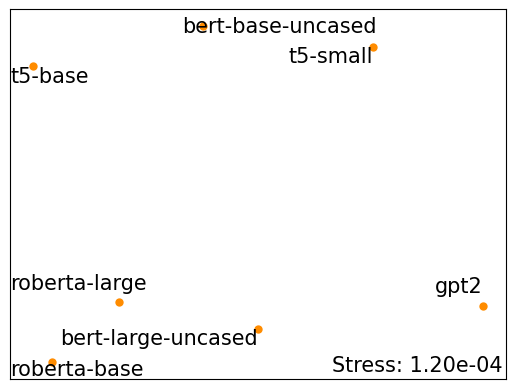

In [546]:
clf = PCA(n_components=2)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#npos = scaler.fit_transform(npos)

fig, ax = plt.subplots()

#ax.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
ax.scatter( npos[:, 1], npos[:, 0], color="darkorange", lw=0, label="NMDS")
#plt.legend(scatterpoints=1, loc="best", shadow=False)

texts = []

# Adding labels to data points
for i, txt in enumerate(models):
    texts.append(ax.text(npos[i][1], npos[i][0], f"{txt}", fontsize=15, ha='center', va='bottom'))

adjust_text(texts)

# If you want to calculate the normalized stress:
normalized_stress = np.sqrt(nmds.stress_) / np.sqrt(np.sum(similarities**2))

print(normalized_stress)

ax.text(0.65, 0.02, f'Stress: {normalized_stress:.2e}', transform=ax.transAxes, fontsize=15)

plt.xticks([])
plt.yticks([])

for i, txt in enumerate(MODELS):
    print(npos[i][0], ',', npos[i][1], ',', txt)

plt.savefig('nmds_actual.pdf')

## accuracy MDS

In [550]:
import pandas as pd

models = [
    "bert-large-uncased",
    "bert-base-uncased",
    "roberta-base",
    "roberta-large",
    "gpt2",
    "t5-base",
    "t5-small",
]

accuracy_vectors = []

for m in models:
    csv_file = f'../data/adversarial-attacks/tf-{m}.csv'

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    successes = np.asarray(df['original_output'] == df['ground_truth_output']).astype(int)
    
    accuracy_vectors.append(successes)

print(accuracy_vectors)

[array([1, 1, 1, ..., 1, 0, 1]), array([1, 1, 1, ..., 1, 0, 1]), array([1, 1, 1, ..., 1, 0, 1]), array([1, 1, 1, ..., 1, 0, 1]), array([1, 1, 1, ..., 1, 0, 1]), array([1, 1, 1, ..., 1, 0, 1]), array([1, 1, 1, ..., 1, 0, 1])]


In [551]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(accuracy_vectors)

seed = 42

mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
    #normalized_stress="auto",
)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
    #normalized_stress=True
)
npos = nmds.fit_transform(similarities, init=pos)

/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/kenneth/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Stress: 6.063448618651728e-08
-0.04062330496877834 , 0.029433709286355195 , bert-large-uncased-imdb
0.09792812713373902 , 0.37372732669354175 , bert-base-uncased-imdb
-0.04058735407853979 , 0.029399091068508052 , roberta-base-imdb
-0.04063885994409531 , 0.029392951307817158 , roberta-large-imdb
-0.7706067840945553 , -0.041783356214968446 , gpt2-imdb
0.0033240833289898027 , -0.33917153320038773 , t5-base-imdb
0.7912040926232398 , -0.08099818894086597 , t5-small-imdb


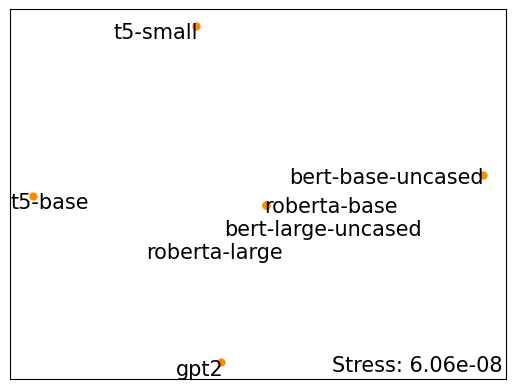

In [553]:
clf = PCA(n_components=2)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#npos = scaler.fit_transform(npos)

fig, ax = plt.subplots()

#ax.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
ax.scatter( npos[:, 1], npos[:, 0], color="darkorange", lw=0, label="NMDS")
#plt.legend(scatterpoints=1, loc="best", shadow=False)

texts = []

# Adding labels to data points
for i, txt in enumerate(models):
    texts.append(ax.text(npos[i][1], npos[i][0], f"{txt}", fontsize=15, ha='center', va='bottom'))

adjust_text(texts)

# If you want to calculate the normalized stress:
normalized_stress = np.sqrt(nmds.stress_) / np.sqrt(np.sum(similarities**2))

print('Stress:', normalized_stress)

ax.text(0.65, 0.02, f'Stress: {normalized_stress:.2e}', transform=ax.transAxes, fontsize=15)

plt.xticks([])
plt.yticks([])

for i, txt in enumerate(MODELS):
    print(npos[i][0], ',', npos[i][1], ',', txt)

plt.savefig('nmds_accuracy.pdf')

In [661]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /home/kenneth/.local/lib/python3.8/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: flair
